In [1]:
from __future__ import annotations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List, Optional, Callable, Any, Dict
from dataclasses import dataclass

import time
import copy
import random
import math
import multiprocessing as mp
from IPython.display import clear_output

In [2]:
# Load the concrete data
df = pd.read_csv("data/concrete_data.csv")

# Display the data
df

,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,concrete_compressive_strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30
...,...,...,...,...,...,...,...,...,...
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.18
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.70
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.77


In [3]:
# Separate into train and test datasets

train_df = df.sample(frac=0.7, random_state=42) # random state ensures we always get the same sample
test_df = df.drop(train_df.index)
train_df.columns

Index(['cement', ' blast_furnace_slag', ' fly_ash', ' water',
       ' superplasticizer', ' coarse_aggregate', ' fine_aggregate', ' age',
       ' concrete_compressive_strength'],
      dtype='object')

In [4]:
# copy the target column from the input data into separate numpy arrays

train_targets = train_df[' concrete_compressive_strength'].to_numpy()
test_targets = test_df[' concrete_compressive_strength'].to_numpy()

test_targets

array([61.89, 44.3 , 42.33, 47.81, 41.84, 28.24, 52.12, 41.72, 53.69,
       38.41, 50.46, 40.76, 33.12, 50.95,  9.87, 48.7 , 33.4 , 28.6 ,
       24.4 , 35.3 , 49.2 , 55.6 , 54.1 , 56.1 , 68.3 , 66.9 , 60.29,
       68.5 , 71.3 , 74.7 , 71.3 , 49.9 , 60.2 , 64.3 , 55.2 , 66.1 ,
       72.99, 79.4 , 77.3 , 59.89, 62.5 , 57.6 , 67.8 , 24.89, 29.45,
       10.38, 22.84, 33.96, 21.06, 26.4 , 35.34, 20.92, 24.9 , 28.47,
       38.56, 10.76,  7.75, 30.39, 50.77, 53.9 , 22.32, 24.54, 31.35,
       40.86, 30.23, 29.22, 38.33, 42.92, 44.4 , 45.08, 15.44, 26.77,
       45.84, 29.65, 13.12, 36.64, 45.37, 48.67, 23.51, 39.15, 55.64,
       52.04, 33.36, 44.14, 42.29, 42.22, 56.85, 21.91, 56.74, 33.73,
       46.64, 50.08, 66.95, 52.2 , 46.23, 31.97, 43.06, 67.57, 41.37,
       60.28, 56.83, 51.02, 44.13, 55.65, 47.28, 29.16, 67.87, 58.52,
       53.58, 14.4 , 21.29, 15.82, 12.55,  8.49, 11.98, 19.42, 41.41,
       27.22, 39.64, 51.26, 55.02, 49.99, 53.66, 56.06, 33.56, 57.03,
       44.42, 53.39,

In [5]:
# drop the target column from the input data to create input feature arrays

train_features = train_df.drop(columns=[' concrete_compressive_strength']).to_numpy()
test_features = test_df.drop(columns=[' concrete_compressive_strength']).to_numpy()

test_features

array([[ 540. ,    0. ,    0. , ..., 1055. ,  676. ,   28. ],
       [ 198.6,  132.4,    0. , ...,  978.4,  825.5,  360. ],
       [ 190. ,  190. ,    0. , ...,  932. ,  670. ,   90. ],
       ...,
       [ 159.8,  250. ,    0. , ..., 1049.3,  688.2,   28. ],
       [ 166. ,  259.7,    0. , ...,  858.8,  826.8,   28. ],
       [ 322.2,    0. ,  115.6, ...,  817.9,  813.4,   28. ]],
      shape=(309, 8))

In [6]:
max_target_value = train_targets.max()
train_targets = train_targets / max_target_value
test_targets = test_targets / max_target_value

In [7]:
# MSE
def mean_squared_error(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return np.mean((y_true - y_pred) ** 2)

# MAE
def mean_absolute_error(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return np.mean(np.abs(y_true - y_pred))

# RMSE
def root_mean_squared_error(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return np.sqrt(mean_squared_error(y_true, y_pred))

# R2
def r2_score(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)

In [8]:
class Layer:
    def __init__(self):
        self.isVectorizable = False

    def forward(self, input_data: np.ndarray) -> np.ndarray:
        raise NotImplementedError("Forward method not implemented.")

    def randomize(self, weight_scale, bias_scale) -> None:
        pass

In [9]:
class ActivationSigmoid(Layer):
    def forward(self, input_data: np.ndarray) -> np.ndarray:
        return 1 / (1 + np.exp(-input_data))

class ActivationReLU(Layer):
    def forward(self, input_data: np.ndarray) -> np.ndarray:
        return np.maximum(0, input_data)

class ActivationTanh(Layer):
    def forward(self, input_data: np.ndarray) -> np.ndarray:
        return np.tanh(input_data)

In [10]:
# create a layer class for the MLP

class Linear(Layer):
    def __init__(self, size_input: int, size_hidden: int):
        """Initialize with weights and biases."""
        self.size_input = size_input
        self.size_hidden = size_hidden
        self.weights = self.init_weights()
        self.bias = self.init_biases()
        self.isVectorizable = True

    def init_weights(self, weight_scale=0.1):
        """Initialize weights."""
        return np.random.randn(self.size_hidden, self.size_input) * weight_scale

    def init_biases(self, bias_scale=0.001):
        """Initialize biases."""
        return np.full((self.size_hidden, 1), bias_scale)

    def randomize(self, weight_scale=0.1, bias_scale=0.001):
        """Randomize weights and biases."""
        self.weights = self.init_weights(weight_scale=weight_scale)
        self.bias = self.init_biases(bias_scale=bias_scale)

    def forward(self, X):
        return np.dot(self.weights, X) + self.bias

    def to_vector(self) -> np.ndarray:
        """Flatten weights and biases into a single vector."""
        return np.concatenate((self.weights.flatten(), self.bias.flatten()))

    def from_vector(self, vector: np.ndarray) -> int:
        """Set weights and biases from a single vector."""
        self.weights = vector[:self.weights.size].reshape(self.weights.shape)
        self.bias = vector[self.weights.size:].reshape(self.bias.shape)

In [11]:
# Test the Linear class
layer = Linear(size_input=5, size_hidden=3)
X_sample = np.random.randn(1, 5).T
output = layer.forward(X_sample)

vector = layer.to_vector()
layer2 = Linear(size_input=5, size_hidden=3)
layer2.from_vector(vector)

print(f"""
bias:
{layer.bias}
weights:
{layer.weights}
input:
{X_sample}
output:
{output}

vector:
{vector}
layer2 bias:
{layer2.bias}
layer2 weights:
{layer2.weights}
""")


bias:
[[0.001]
 [0.001]
 [0.001]]
weights:
[[-0.12371272  0.08457245 -0.16923142  0.0058808  -0.18505051]
 [-0.06668216  0.13284941 -0.05112891 -0.11687925 -0.01673997]
 [-0.05532834 -0.03315371 -0.01871928 -0.10284434  0.02658368]]
input:
[[ 0.58578008]
 [ 1.51676275]
 [ 0.64277151]
 [-3.16637002]
 [-0.3927995 ]]
output:
[[0.00209772]
 [0.50723414]
 [0.22147241]]

vector:
[-0.12371272  0.08457245 -0.16923142  0.0058808  -0.18505051 -0.06668216
  0.13284941 -0.05112891 -0.11687925 -0.01673997 -0.05532834 -0.03315371
 -0.01871928 -0.10284434  0.02658368  0.001       0.001       0.001     ]
layer2 bias:
[[0.001]
 [0.001]
 [0.001]]
layer2 weights:
[[-0.12371272  0.08457245 -0.16923142  0.0058808  -0.18505051]
 [-0.06668216  0.13284941 -0.05112891 -0.11687925 -0.01673997]
 [-0.05532834 -0.03315371 -0.01871928 -0.10284434  0.02658368]]



In [12]:
class Sequential:
    def __init__(self, *layers: Layer, randomize: bool = True):
        self.layers = layers
        self.vectorizable_layers: List[Linear] = [layer for layer in self.layers if layer.isVectorizable]
        self.vector_indexes = []
        index = 0
        for layer in self.vectorizable_layers:
            size_layer_params = layer.weights.size + layer.bias.size
            self.vector_indexes.append((index, index + size_layer_params))
            index += size_layer_params

        if randomize:
            self.randomize()

    def randomize(self, weight_scale=0.1, bias_scale=0.001):
        for layer in self.layers:
            layer.randomize(weight_scale=weight_scale, bias_scale=bias_scale)

    def forward(self, X: np.ndarray) -> np.ndarray:
        output = X
        for layer in self.layers:
            output = layer.forward(output)
        return output

    def to_vector(self) -> np.ndarray:
        """Concatenate parameters from all layers into a single vector."""
        param_vector = np.array([])
        for layer in self.vectorizable_layers:
            param_vector = np.concatenate((param_vector, layer.to_vector()))
        return param_vector

    def from_vector(self, param_vector: np.ndarray):
        """Set parameters from all layers from a single vector."""
        for i in range(len(self.vectorizable_layers)):
            start_idx, end_idx = self.vector_indexes[i]
            self.vectorizable_layers[i].from_vector(param_vector[start_idx:end_idx])

In [13]:
# Test the Sequential class

mlp = Sequential(
    Linear(size_input=5, size_hidden=3),
    ActivationReLU(),
    Linear(size_input=3, size_hidden=4),
    ActivationSigmoid(),
    Linear(size_input=4, size_hidden=1)
)
X_sample = np.random.randn(1, 5).T
output = mlp.forward(X_sample)
vector = mlp.to_vector()
print(f"""
input:
{X_sample}
output:
{output}

vector:
{vector}
""")

mlp.randomize()
print(f"""
initial model2 output:
{mlp.forward(X_sample)}
""")

mlp.from_vector(vector)
print(f"""model2 output after from_vector:
{mlp.forward(X_sample)}
""")


input:
[[ 0.44390077]
 [ 0.00694555]
 [-1.03990713]
 [-1.65346617]
 [-2.15941018]]
output:
[[-0.06047346]]

vector:
[ 0.02460011  0.11573055  0.08787026  0.10130325 -0.02665505  0.0264727
 -0.12350594 -0.03511868 -0.08078707 -0.04476722  0.01436895 -0.02303657
 -0.13193137  0.02265369 -0.03431822  0.001       0.001       0.001
 -0.03537712  0.10110405  0.06288978  0.03164456 -0.04511364 -0.03702526
  0.00948802  0.00247516 -0.10865817  0.06168646  0.04342818  0.10446368
  0.001       0.001       0.001       0.001       0.0966726  -0.04528162
 -0.06505013 -0.11047835  0.001     ]


initial model2 output:
[[-0.13141654]]

model2 output after from_vector:
[[-0.06047346]]



In [14]:
# Creation of AI class for training the MLP with our PSO

@dataclass
class AccelerationCoefficients:
    inertia_weight: float
    cognitive_weight: float
    social_weight: float
    global_best_weight: float
    jump_size: float
    max_velocity: float
    max_position: float

class Particle:
    def __init__(self, position: np.ndarray, accel_coeff: AccelerationCoefficients, fitness: float):
        self.accel_coeff = accel_coeff
        # Initialize other attributes like position, velocity, personal best, etc.
        self.position = position
        self.velocity = np.random.randn(position.shape[0]) * 0.1
        self.fittest = fitness
        self.informants: List[Particle] = []

        self.best_personal: np.ndarray = position.copy()

    def get_best_informant(self):
        informant_fittest = None
        best_informant = None
        for informant in self.informants:
            if best_informant is None or informant.fittest < informant_fittest:
                informant_fittest = informant.fittest
                best_informant = informant
        return best_informant.position

    def update_velocity(self, best_global):
        best_informant = self.get_best_informant()
        for i in range(len(self.position)):
            b = np.random.random() * self.accel_coeff.cognitive_weight
            c = np.random.random() * self.accel_coeff.social_weight
            d = np.random.random() * self.accel_coeff.global_best_weight
            inertia = self.accel_coeff.inertia_weight * self.velocity[i]
            velocity_cognitive = b * (self.best_personal[i] - self.position[i])
            velocity_social = c * (best_informant[i] - self.position[i])
            velocity_global = d * (best_global[i] - self.position[i])
            new_velocity = inertia + velocity_cognitive + velocity_social + velocity_global
            self.velocity[i] = np.clip(new_velocity, -self.accel_coeff.max_velocity, self.accel_coeff.max_velocity)

    def update_position(self):
        self.position += self.velocity * self.accel_coeff.jump_size
        self.position = np.clip(self.position, -self.accel_coeff.max_position, self.accel_coeff.max_position)

class ParticleSwarmOptimisation:
    def __init__(
            self,
            X: np.ndarray[tuple[int, int]],
            Y: np.ndarray[tuple[int]],
            swarm_size: int,
            accel_coeff: AccelerationCoefficients,
            num_informants: int,
            loss_function,
            particle_initial_position_scale: Tuple[float, float],
            model: Sequential,
        ):
        self.accel_coeff = accel_coeff
        self.swarm_size = swarm_size
        self.num_informants = num_informants

        self.X = X
        self.Y = Y

        self.loss_function = loss_function
        self.model = model

        self.losses = []
        self.avg_fitnesses = []

        self.population: List[Particle] = []
        for _ in range(swarm_size):
            self.model.randomize(weight_scale=particle_initial_position_scale[0], bias_scale=particle_initial_position_scale[1])
            particle_fitness = self.loss_function(self.Y, self.model.forward(self.X))
            self.population.append(Particle(position=self.model.to_vector(), accel_coeff=accel_coeff, fitness=particle_fitness))

        self.best_global: np.ndarray = self.population[0].position.copy()
        self.best_global_fitness: float = self.population[0].fittest

    def update_informants(self):
        if self.num_informants >= self.swarm_size:
            raise ValueError("Number of informants must be less than swarm size.")
        for particle in self.population:
            others = [p for p in self.population if p is not particle]
            particle.informants = np.random.choice(others, size=self.num_informants, replace=False)

    def update_best_global(self):
        loss = 0.0
        fitnesses = []
        for particle in self.population:
            self.model.from_vector(particle.position)
            fitness = self.loss_function(self.Y, self.model.forward(self.X))
            fitnesses.append(fitness)
            loss += fitness
            if fitness < particle.fittest:
                particle.best_personal = particle.position.copy()
                particle.fittest = fitness
                if self.best_global_fitness is None or fitness < self.best_global_fitness:
                    self.best_global = particle.position.copy()
                    self.best_global_fitness = fitness
        return np.mean(fitnesses)

    def get_accuracy(self, x, y_true) -> float:
        """Evaluate the accuracy in percent of the best global model on given data."""
        self.model.from_vector(self.best_global)
        y_pred = self.model.forward(x)

        mae = mean_absolute_error(y_true, y_pred)
        accuracy = 100 * (1.0 - mae / np.mean(np.abs(y_true)))

        return accuracy

    def update_velocities(self):
        for particle in self.population:
            particle.update_velocity(self.best_global)

    def update_positions(self):
        for particle in self.population:
            particle.update_position()

    def plot(self, epoch, avg_fitness):
        if epoch % 10 == 0:
            self.avg_fitnesses.append(avg_fitness)
            self.losses.append(self.best_global_fitness)
            fig, ax = plt.subplots()
            ax.plot(self.losses, label="Loss")
            ax.plot(
                self.avg_fitnesses,
                label="Average Fitness",
                linestyle="--"
            )
            ax.set_xlabel("Step")
            ax.set_ylabel("Loss")
            ax.set_title("Training Loss")
            ax.legend()

            clear_output(wait=True)
            display(fig)
            plt.close(fig)
            
    def train_epoch(self):
        avg_fitness = self.update_best_global()
        self.update_velocities()
        self.update_positions()
        return avg_fitness

    def train(self, epochs):
        self.update_informants()
        for epoch in range(epochs):
            avg_fitness = self.train_epoch()
            self.plot(epoch, avg_fitness)
        return (self.best_global, self.best_global_fitness, self.losses)

In [15]:
# Creation of AI class for training the MLP with our PSO


@dataclass
class AccelerationCoefficients:
    inertia_weight: float
    cognitive_weight: float
    social_weight: float
    global_best_weight: float
    jump_size: float
    max_velocity: float
    max_position: float


class Particle:
    def __init__(
        self,
        position: np.ndarray,
        accel_coeff: AccelerationCoefficients,
        fitness: float,
    ):
        self.accel_coeff = accel_coeff
        # Initialize other attributes like position, velocity, personal best, etc.
        self.position = position
        self.velocity = np.random.randn(position.shape[0]) * 0.1
        self.fittest = fitness
        self.informants: List[Particle] = []

        self.best_personal: np.ndarray = position.copy()

    def get_best_informant(self):
        informant_fittest = None
        best_informant = None
        for informant in self.informants:
            if best_informant is None or informant.fittest < informant_fittest:
                informant_fittest = informant.fittest
                best_informant = informant
        return best_informant.position

    def update_velocity(self, best_global):
        best_informant = self.get_best_informant()
        for i in range(len(self.position)):
            b = np.random.random() * self.accel_coeff.cognitive_weight
            c = np.random.random() * self.accel_coeff.social_weight
            d = np.random.random() * self.accel_coeff.global_best_weight
            inertia = self.accel_coeff.inertia_weight * self.velocity[i]
            velocity_cognitive = b * (self.best_personal[i] - self.position[i])
            velocity_social = c * (best_informant[i] - self.position[i])
            velocity_global = d * (best_global[i] - self.position[i])
            new_velocity = (
                inertia + velocity_cognitive + velocity_social + velocity_global
            )
            self.velocity[i] = np.clip(
                new_velocity,
                -self.accel_coeff.max_velocity,
                self.accel_coeff.max_velocity,
            )

    def update_position(self):
        self.position += self.velocity * self.accel_coeff.jump_size
        self.position = np.clip(
            self.position, -self.accel_coeff.max_position, self.accel_coeff.max_position
        )


class ParticleSwarmOptimisation:
    def __init__(
        self,
        X: np.ndarray[tuple[int, int]],
        Y: np.ndarray[tuple[int]],
        swarm_size: int,
        accel_coeff: AccelerationCoefficients,
        num_informants: int,
        loss_function,
        particle_initial_position_scale: Tuple[float, float],
        model: Sequential,
    ):
        self.accel_coeff = accel_coeff
        self.swarm_size = swarm_size
        self.num_informants = num_informants

        self.X = X
        self.Y = Y

        self.loss_function = loss_function
        self.model = model

        self.losses = []
        self.avg_fitnesses = []

        self.population: List[Particle] = []
        for _ in range(swarm_size):
            self.model.randomize(
                weight_scale=particle_initial_position_scale[0],
                bias_scale=particle_initial_position_scale[1],
            )
            particle_fitness = self.loss_function(self.Y, self.model.forward(self.X))
            self.population.append(
                Particle(
                    position=self.model.to_vector(),
                    accel_coeff=accel_coeff,
                    fitness=particle_fitness,
                )
            )

        self.best_global: np.ndarray = self.population[0].position.copy()
        self.best_global_fitness: float = self.population[0].fittest

    def update_informants_random(self):
        if self.num_informants >= self.swarm_size:
            raise ValueError("Number of informants must be less than swarm size.")
        for particle in self.population:
            others = [p for p in self.population if p is not particle]
            particle.informants = np.random.choice(
                others, size=self.num_informants, replace=False
            )

    def update_informants_nearest(self):
        if self.num_informants >= self.swarm_size:
            raise ValueError("Number of informants must be less than swarm size.")
        for particle in self.population:
            distances = []
            for other in self.population:
                if other is not particle:
                    dist = np.linalg.norm(particle.position - other.position)
                    distances.append((dist, other))
            distances.sort(key=lambda x: x[0])
            particle.informants = [distances[i][1] for i in range(self.num_informants)]

    def update_best_global(self):
        loss = 0.0
        fitnesses = []
        for particle in self.population:
            self.model.from_vector(particle.position)
            fitness = self.loss_function(self.Y, self.model.forward(self.X))
            fitnesses.append(fitness)
            loss += fitness
            if fitness < particle.fittest:
                particle.best_personal = particle.position.copy()
                particle.fittest = fitness
                if (
                    self.best_global_fitness is None
                    or fitness < self.best_global_fitness
                ):
                    self.best_global = particle.position.copy()
                    self.best_global_fitness = fitness
        return np.mean(fitnesses)

    def get_accuracy(self, x, y_true) -> float:
        """Evaluate the accuracy in percent of the best global model on given data."""
        self.model.from_vector(self.best_global)
        y_pred = self.model.forward(x)

        mae = mean_absolute_error(y_true, y_pred)
        accuracy = 100 * (1.0 - mae / np.mean(np.abs(y_true)))

        return accuracy

    def update_velocities(self):
        for particle in self.population:
            particle.update_velocity(self.best_global)

    def update_positions(self):
        for particle in self.population:
            particle.update_position()

    def plot(self, epoch, avg_fitness):
        if epoch % 1 == 0:
            self.avg_fitnesses.append(avg_fitness)
            self.losses.append(self.best_global_fitness)
            fig, ax = plt.subplots()
            ax.plot(self.losses, label="Loss")
            ax.plot(self.avg_fitnesses, label="Average Fitness", linestyle="--")
            ax.set_xlabel("Step")
            ax.set_ylabel("Loss")
            ax.set_title("Training Loss")
            ax.legend()

            clear_output(wait=True)
            display(fig)
            plt.close(fig)

    def train_epoch(self):
        avg_fitness = self.update_best_global()
        self.update_velocities()
        self.update_positions()
        return avg_fitness

    def train(self, epochs):
        # self.update_informants_random()
        for epoch in range(epochs):
            self.update_informants_nearest()
            avg_fitness = self.train_epoch()
            self.plot(epoch, avg_fitness)
        return (self.best_global, self.best_global_fitness, self.losses)




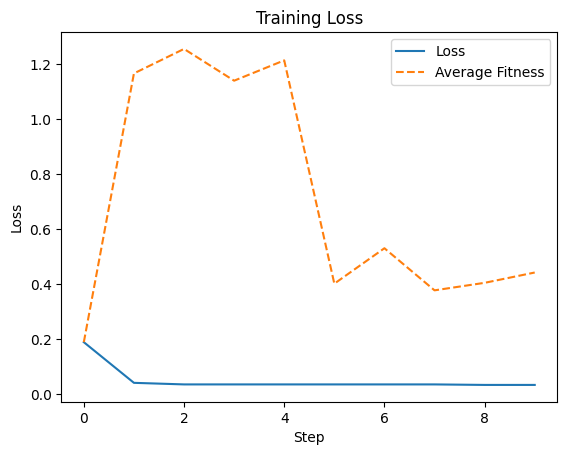

Test Accuracy: 68.10%
Train Accuracy: 65.68%

===== Summary over 10 runs =====
Average loss: 0.0302
Average train accuracy: 67.58%
Average test accuracy:  69.91%
Train accuracy std: 2.13
Test accuracy std:  1.94


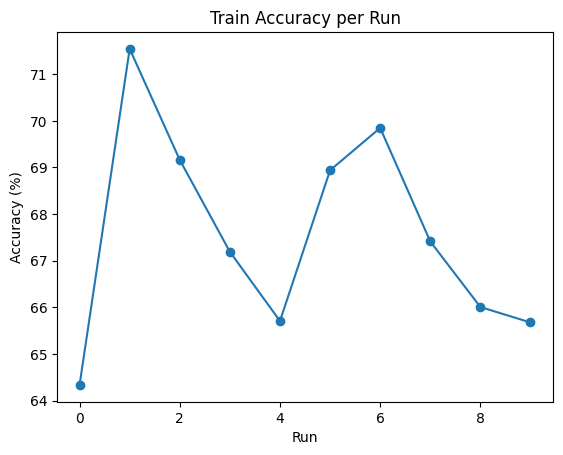

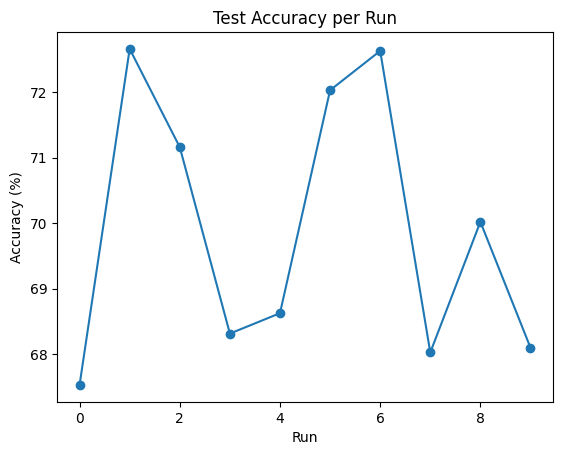

In [23]:

from datetime import datetime
import os

# Timestamp for the entire experiment
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Main output directory
main_dir = f"./results/run_{timestamp}"
os.makedirs(main_dir, exist_ok=True)

all_final_train_accuracies = []
all_final_test_accuracies = []
all_final_losses = []


for run_id in range(1, 11):

    mlp = Sequential(
        Linear(size_input=train_features.shape[1], size_hidden=8),
        ActivationReLU(),
        Linear(size_input=8, size_hidden=4),
        ActivationReLU(),
        Linear(size_input=4, size_hidden=1),
    )

    # predictions = mlp.forward(test_features.T)

    # plt.scatter(test_targets, predictions)
    # plt.xlabel("True Values")
    # plt.ylabel("Predictions")
    # plt.title("Predictions vs True Values")
    # plt.plot([test_targets.min(), test_targets.max()], [test_targets.min(), test_targets.max()], 'k--', lw=2)
    # plt.show()

    swarm_size = 45
    epochs = 10
    accel_coeff = AccelerationCoefficients(
        inertia_weight=0.708,
        cognitive_weight=1.898,
        social_weight=0.351,
        global_best_weight=0.684,
        jump_size=0.851,
        max_velocity=0.9,
        max_position=3.87,
    )
    num_informants = 4
    particle_initial_position_scale = (0.0001, 0.05)
    loss_function = mean_squared_error

    pso = ParticleSwarmOptimisation(
        X=train_features.T,
        Y=train_targets,
        swarm_size=swarm_size,
        accel_coeff=accel_coeff,
        num_informants=num_informants,
        loss_function=loss_function,
        particle_initial_position_scale=particle_initial_position_scale,
        model=mlp,
    )

    (final_position, final_score, losses) = pso.train(epochs)
    # print(f"Final particle fitness: {final_score}")
    # print(f"Final particle position sample: {final_position[:5]}")
    mlp.from_vector(final_position)
    # predictions = mlp.forward(test_features.T)

    # plt.scatter(test_targets, predictions)
    # plt.xlabel("True Values")
    # plt.ylabel("Predictions")
    # plt.title("Predictions vs True Values")
    # plt.plot(
    #     [test_targets.min(), test_targets.max()],
    #     [test_targets.min(), test_targets.max()],
    #     "k--",
    #     lw=2,
    # )
    # plt.show()

    # plt.plot(losses)
    # plt.yscale("log")
    # plt.xlabel("Epoch")
    # plt.ylabel("Loss")
    # plt.title("Training Loss over Epochs")
    # plt.show()

    # Accuracy
    test_accuracy = pso.get_accuracy(test_features.T, test_targets)
    print(f"Test Accuracy: {test_accuracy:.2f}%")

    all_final_test_accuracies.append(test_accuracy)

    train_accuracy = pso.get_accuracy(train_features.T, train_targets)
    print(f"Train Accuracy: {train_accuracy:.2f}%")

    all_final_train_accuracies.append(train_accuracy)

    all_final_losses.append(final_score)

    # print(f"""
    # Params:
    # model: MLP with layers {[type(layer).__name__ for layer in mlp.layers]}
    # swarm_size: {swarm_size}
    # epochs: {epochs}
    # accel_coeff: {accel_coeff}
    # num_informants: {num_informants}
    # loss_function: {loss_function.__name__}
    # """)

avg_loss = np.mean(all_final_losses)
avg_train_acc = np.mean(all_final_train_accuracies)
avg_test_acc = np.mean(all_final_test_accuracies)

std_train_acc = np.std(all_final_train_accuracies)
std_test_acc = np.std(all_final_test_accuracies)

print("\n===== Summary over 10 runs =====")
print(f"Average loss: {avg_loss:.4f}")
print(f"Average train accuracy: {avg_train_acc:.2f}%")
print(f"Average test accuracy:  {avg_test_acc:.2f}%")
print(f"Train accuracy std: {std_train_acc:.2f}")
print(f"Test accuracy std:  {std_test_acc:.2f}")

# plt.figure()
# plt.plot(all_final_losses, marker="o")
# plt.title("Final Loss per Run")
# plt.xlabel("Run")
# plt.ylabel("Loss")
# plt.show()

plt.figure()
plt.plot(all_final_train_accuracies, marker="o")
plt.title("Train Accuracy per Run")
plt.xlabel("Run")
plt.ylabel("Accuracy (%)")
plt.savefig(f"{main_dir}/final train accuracies.png")
plt.show()

plt.figure()
plt.plot(all_final_test_accuracies, marker="o")
plt.title("Test Accuracy per Run")
plt.xlabel("Run")
plt.ylabel("Accuracy (%)")
plt.savefig(f"{main_dir}/final test accuracies.png")
plt.show()

summary_path = f"{main_dir}/experiment_summary.txt"
with open(summary_path, "w") as f:

    f.write("===== GLOBAL EXPERIMENT SUMMARY =====\n\n")

    f.write("=== ANN Structure ===\n")
    f.write("Topology: 8-4-1 with ReLU activations\n\n")

    f.write("=== PSO Hyperparameters ===\n")
    f.write(f"Swarm size: {swarm_size}\n")
    f.write(f"Epochs: {epochs}\n")
    f.write(f"Inertia: {accel_coeff.inertia_weight}\n")
    f.write(f"Cognitive: {accel_coeff.cognitive_weight}\n")
    f.write(f"Social: {accel_coeff.social_weight}\n")
    f.write(f"Global best weight: {accel_coeff.global_best_weight}\n")
    f.write(f"Jump size: {accel_coeff.jump_size}\n")
    f.write(f"Max velocity: {accel_coeff.max_velocity}\n")
    f.write(f"Max position: {accel_coeff.max_position}\n")
    f.write(f"Informants: {num_informants}\n")
    f.write(f"Initial position scale: {particle_initial_position_scale}\n\n")

    f.write("=== RESULTS OVER 10 RUNS ===\n")
    for i in range(10):
        f.write(f"Run {i+1}: Loss = {all_final_losses[i]:.5f}, "
                f"Train Acc = {all_final_train_accuracies[i]:.2f}%, "
                f"Test Acc = {all_final_test_accuracies[i]:.2f}%\n")

    f.write("\n=== Averages ===\n")
    f.write(f"Average Loss: {np.mean(all_final_losses):.6f}\n")
    f.write(f"Average Train Accuracy: {np.mean(all_final_train_accuracies):.2f}%\n")
    f.write(f"Average Test Accuracy: {np.mean(all_final_test_accuracies):.2f}%\n\n")

    f.write("=== Standard Deviations ===\n")
    f.write(f"Std Train Acc: {np.std(all_final_train_accuracies):.2f}\n")
    f.write(f"Std Test Acc: {np.std(all_final_test_accuracies):.2f}\n")


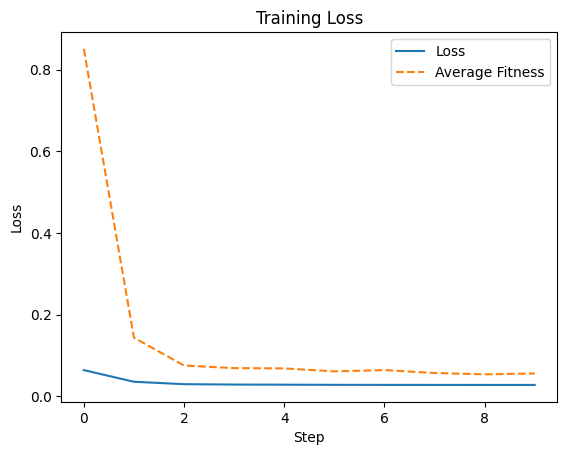

Run 10: Final particle fitness: 0.027720501963114052
Mean Test Accuracy over 10 runs: 69.14% ± 2.40%


In [ ]:
# Evaluate fitness of a Pso tentatives times
mlp = Sequential(
    Linear(size_input=train_features.shape[1], size_hidden=12),
    ActivationReLU(),
    Linear(size_input=12, size_hidden=12),
    ActivationReLU(),
    Linear(size_input=12, size_hidden=1),
)

swarm_size = 20
epochs = 60
accel_coeff = AccelerationCoefficients(
        inertia_weight=0.68,
        cognitive_weight=2.80,
        social_weight=0.88,
        global_best_weight=0.96,
        jump_size=0.6,
        max_velocity=0.9,
        max_position=3.87,
    )
num_informants = 4
particle_initial_position_scale = (0.0001, 0.087)
loss_function = mean_squared_error

tentatives = 20

final_scores = []
accuracies = []

for i in range(tentatives):
    pso = ParticleSwarmOptimisation(
        X=train_features.T,
        Y=train_targets,
        swarm_size=swarm_size,
        accel_coeff=accel_coeff,
        num_informants=num_informants,
        loss_function=loss_function,
        particle_initial_position_scale=particle_initial_position_scale,
        model=mlp
    )
    (final_position, final_score, losses) = pso.train(epochs=epochs)
    accuracy = pso.get_accuracy(test_features.T, test_targets)
    print(f"Run {i+1}: Final particle fitness: {final_score}")
    final_scores.append(final_score)
    accuracies.append(accuracy)


# Histogram that shows accuracy in x and pso that gives that accuracy in y
plt.hist(accuracies, bins=10, edgecolor='black')
plt.xlabel("Test Accuracy (%)")
plt.ylabel("Number of PSO runs")
plt.title("Distribution of Test Accuracies over PSO Runs")
plt.show()

# Print mean accuracy
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)
print(f"Mean Test Accuracy over {tentatives} runs: {mean_accuracy:.2f}% ± {std_accuracy:.2f}%")

# random : 74.16 +- 2 (20t, 28s)
# random : 74.15 +- 2.66 (40t, 56s)
# nearest : 72.46 +- 2.35 (40t, 58.6)

In [17]:
# @dataclass
# class PsoGenome:
#     swarm_size: int
#     accel_coeff: AccelerationCoefficients
#     num_informants: int
#     particle_initial_position_scale: Tuple[float, float]
#     loss_function: callable

#     def crossovers(self, other: 'PsoGenome') -> 'PsoGenome':
#         # Implement crossover logic
#         pass

# class GeneticIndividual:
#     def __init__(self, genome: np.ndarray):
#         self.genome = genome
#         self.fitness: float = float('inf')

# class GeneticPsoOptimizer:
#     def __init__(self, population_size: int, mutation_rate: float, crossover_rate: float, model: Sequential, loss_function):
#         self.population_size = population_size
#         self.mutation_rate = mutation_rate
#         self.crossover_rate = crossover_rate
#         self.loss_function = loss_function
#         self.population: List[GeneticIndividual] = []
#         self.fitnesses: List[float] = [self.evaluate_fitness(individual) for individual in self.population]

#     def evaluate_fitness(self, individual: ParticleSwarmOptimisation) -> float:
#         pass

In [18]:
# Genetic Algorithm for PSO Hyperparameter Optimization generated by ChatGPT
# It is designed to find the best genome (hyperparameters of the PSO) because they are hard to fine tune by hand

# --- Genome definition -----------------------------------------------------

@dataclass
class AccelerationCoefficientsGenome:
    inertia_weight: float
    cognitive_weight: float
    social_weight: float
    global_best_weight: float
    jump_size: float
    max_velocity: float
    max_position: float

    def mutate(self, mutation_rate: float, ranges: Dict[str, Tuple[float, float]]):
        # gaussian perturbation per field with chance
        for name in vars(self):
            if random.random() < mutation_rate:
                lo, hi = ranges[name]
                cur = getattr(self, name)
                # relative gaussian step
                step = (hi - lo) * 0.1
                new = cur + random.gauss(0, step)
                setattr(self, name, float(np.clip(new, lo, hi)))

    @staticmethod
    def crossover(a: 'AccelerationCoefficientsGenome', b: 'AccelerationCoefficientsGenome') -> 'AccelerationCoefficientsGenome':
        # uniform crossover
        out = {}
        for name in vars(a):
            out[name] = getattr(a, name) if random.random() < 0.5 else getattr(b, name)
        return AccelerationCoefficientsGenome(**out)

@dataclass
class PsoGenome:
    swarm_size: int
    accel: AccelerationCoefficientsGenome
    num_informants: int
    particle_initial_position_scale: Tuple[float, float]
    # optionally include model architecture: list of hidden layer sizes and activation names
    ann_layers: Optional[Tuple[int, ...]] = None
    ann_activation: str = "tanh"
    # keep a pointer/identifier to the loss function if desired (not serializable)
    # loss_function: Callable = field(default=None, repr=False)

    def copy(self) -> 'PsoGenome':
        return copy.deepcopy(self)

    def mutate(self, mutation_rate: float, bounds: dict):
        # mutate swarm size (discrete), num_informants (discrete), scales and accel
        if random.random() < mutation_rate:
            self.swarm_size = int(np.clip(self.swarm_size + random.randint(-4, 4), bounds['swarm_size'][0], bounds['swarm_size'][1]))
        if random.random() < mutation_rate:
            self.num_informants = int(np.clip(self.num_informants + random.randint(-2, 2), 1, max(1, self.swarm_size - 1)))
        if random.random() < mutation_rate:
            s0, s1 = self.particle_initial_position_scale
            s0 += random.gauss(0, (bounds['position_scale'][1] - bounds['position_scale'][0]) * 0.05)
            s1 += random.gauss(0, (bounds['bias_scale'][1] - bounds['bias_scale'][0]) * 0.05)
            self.particle_initial_position_scale = (float(np.clip(s0, bounds['position_scale'][0], bounds['position_scale'][1])),
                                                   float(np.clip(s1, bounds['bias_scale'][0], bounds['bias_scale'][1])))
        # mutate acceleration coeffs
        self.accel.mutate(mutation_rate, bounds['accel_ranges'])
        # mutate architecture (small chance)
        if self.ann_layers is not None and random.random() < mutation_rate:
            layers = list(self.ann_layers)
            if random.random() < 0.5 and len(layers) > 0:
                # tweak a layer size
                idx = random.randrange(len(layers))
                layers[idx] = int(np.clip(layers[idx] + random.randint(-8, 8), 1, 1024))
            else:
                # either add or remove layer
                if random.random() < 0.5 and len(layers) > 1:
                    layers.pop(random.randrange(len(layers)))
                else:
                    # add a small layer
                    insert_at = random.randrange(len(layers)+1)
                    layers.insert(insert_at, random.randint(1, 32))
            self.ann_layers = tuple(layers)

    @staticmethod
    def crossover(a: 'PsoGenome', b: 'PsoGenome', crossover_rate: float = 0.5) -> 'PsoGenome':
        # single-point for architecture, uniform for many numeric
        child = a.copy()
        # swarm size: average with some chance
        child.swarm_size = int((a.swarm_size if random.random() < 0.5 else b.swarm_size))
        child.num_informants = int((a.num_informants if random.random() < 0.5 else b.num_informants))
        child.particle_initial_position_scale = (a.particle_initial_position_scale if random.random() < 0.5 else b.particle_initial_position_scale)
        child.accel = AccelerationCoefficientsGenome.crossover(a.accel, b.accel)
        # architecture crossover (if both defined)
        if a.ann_layers and b.ann_layers:
            if random.random() < crossover_rate:
                # one-point crossover on layer lists
                la, lb = list(a.ann_layers), list(b.ann_layers)
                cut_a = random.randrange(len(la))
                cut_b = random.randrange(len(lb))
                new_layers = tuple(la[:cut_a] + lb[cut_b:])
                child.ann_layers = new_layers
        else:
            child.ann_layers = a.ann_layers or b.ann_layers
        return child

# --- Evaluator -------------------------------------------------------------

class PsoEvaluator:
    def __init__(
        self,
        X: np.ndarray,
        Y: np.ndarray,
        X_test: np.ndarray,
        Y_test: np.ndarray,
        base_model_builder: Callable[[PsoGenome], Any],
        loss_function: Callable[[np.ndarray, np.ndarray], float],
        max_train_seconds: float = 10.0,
        patience_window: int = 20,
        num_genome_repeats_per_iteration: int = 3,
        max_repeats_per_genome: int = 30,
        explosion_factor: float = 1e6,
        accuracy_checks_every: int = 10,
        verbose: bool = False
    ):
        """
        base_model_builder: function(genome)->model where model implements the interface expected by ParticleSwarmOptimisation:
            - randomize(weight_scale, bias_scale)
            - to_vector()/from_vector()
            - forward(X)
        """
        self.X = X
        self.Y = Y
        self.X_test = X_test
        self.Y_test = Y_test
        self.base_model_builder = base_model_builder
        self.loss_function = loss_function
        self.max_train_seconds = max_train_seconds
        self.patience_window = patience_window
        self.num_genome_repeats_per_iteration = num_genome_repeats_per_iteration
        self.max_repeats_per_genome = max_repeats_per_genome
        self.explosion_factor = explosion_factor
        self.accuracy_checks_every = accuracy_checks_every
        self.verbose = verbose
        
        self.cache: Dict[str, Dict[str, Any]] = {}

    def evaluate(self, genome: PsoGenome) -> float:
        """
        Returns scalar fitness. Lower is better.
        Implements:
         - time-limited training
         - early stopping on recent-window no-improvement (penalise)
         - explosion detection (penalise)
        """
        key = str(genome)
        if key in self.cache and self.cache[key]['repeats'] >= self.max_repeats_per_genome:
            return self.cache[key]['acc']

        # build model
        model = self.base_model_builder(genome)

        # build PSO with the genome's params
        accel = genome.accel
        accel_obj = AccelerationCoefficients(
            inertia_weight=accel.inertia_weight,
            cognitive_weight=accel.cognitive_weight,
            social_weight=accel.social_weight,
            global_best_weight=accel.global_best_weight,
            jump_size=accel.jump_size,
            max_velocity=accel.max_velocity,
            max_position=accel.max_position
        )
        
        accuracies = []
        
        for _ in range(self.num_genome_repeats_per_iteration):
            pso = ParticleSwarmOptimisation(
                X=self.X, Y=self.Y,
                swarm_size=genome.swarm_size,
                accel_coeff=accel_obj,
                num_informants=max(1, min(genome.num_informants, genome.swarm_size - 1)),
                loss_function=self.loss_function,
                particle_initial_position_scale=genome.particle_initial_position_scale,
                model=model
            )

            start_time = time.time()
            last_losses = []
            try:
                epoch = 0
                # replace PSO.train loop with a time-aware training
                pso.update_informants()
                # compute an initial loss to detect explosion (if available)
                # We'll compute first fitness properly
                initial_fitness = pso.update_best_global()
                while True:
                    # check time limit
                    if time.time() - start_time > self.max_train_seconds:
                        break
                    # iterate a small PSO step: velocities, positions, recompute bests
                    pso.update_velocities()
                    pso.update_positions()
                    avg_fitness = pso.update_best_global()
                    last_losses.append(pso.best_global_fitness)

                    # explosion detection
                    if avg_fitness > initial_fitness * self.explosion_factor:
                        # heavy penalty
                        if self.verbose:
                            print("[eval] explosion detected. stopping early.")
                        accuracies.append(0.0)
                        break

                    if epoch % self.accuracy_checks_every == 0:
                        acc = pso.get_accuracy(self.X_test, self.Y_test)
                        accuracies.append(acc)
                    # early stopping: check last window
                    if len(last_losses) > self.patience_window:
                        # consider improvement if best decreased at least once in window
                        window = last_losses[-self.patience_window:]
                        if max(window) < window[0]:  # no improvement
                            if self.verbose:
                                print(f"[eval] early stopping at epoch {epoch}")
                            accuracies.append(pso.get_accuracy(self.X_test, self.Y_test))
                            break
                    epoch += 1
                # normal return: the best found
                acc = pso.get_accuracy(self.X_test, self.Y_test)
                if self.verbose:
                    print(f"[eval] completed training epochs: {epoch}, accuracy: {acc:.6g}")
                accuracies.append(acc)
            except Exception as e:
                # crash in training -> penalize heavily
                if self.verbose:
                    print("[eval] Exception during PSO eval:", e)
                accuracies.append(0.0)
            
        if key in self.cache:
            self.cache[key]['repeats'] += self.num_genome_repeats_per_iteration
        else:
            self.cache[key] = {'repeats': self.num_genome_repeats_per_iteration, 'accuracies': []}
        updated_accuracies = self.cache[key]['accuracies'] + accuracies
        mean_accuracy = np.mean(updated_accuracies)
        self.cache[key]['acc'] = mean_accuracy

        return mean_accuracy

# --- Genetic algorithm ----------------------------------------------------

@dataclass
class GeneticIndividual:
    genome: PsoGenome
    accuracy: float = float('inf')

class GeneticPsoOptimizer:
    def __init__(
        self,
        evaluator: PsoEvaluator,
        population_size: int = 20,
        generations: int = 30,
        mutation_rate: float = 0.1,
        crossover_rate: float = 0.8,
        elitism: int = 2,
        tournament_k: int = 3,
        parallel: bool = True,
    ):
        self.evaluator = evaluator
        self.population_size = population_size
        self.generations = generations
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.elitism = elitism
        self.tournament_k = tournament_k
        self.parallel = parallel
        self.population: List[GeneticIndividual] = []

    def initialize(self, seed_genome_factory: Callable[[], PsoGenome]):
        self.population = [GeneticIndividual(seed_genome_factory()) for _ in range(self.population_size)]

    def evaluate_population(self):
        # Evaluate all individuals (optionally in parallel)
        if self.parallel:
            with mp.Pool(max(1, mp.cpu_count() - 1)) as pool:
                genomes = [ind.genome for ind in self.population]
                results = pool.map(self.evaluator.evaluate, genomes)
            for ind, f in zip(self.population, results):
                ind.accuracy = f
        else:
            for ind in self.population:
                ind.accuracy = self.evaluator.evaluate(ind.genome)

    def tournament_select(self) -> PsoGenome:
        contenders = random.sample(self.population, self.tournament_k)
        best = max(contenders, key=lambda ind: ind.accuracy)
        return best.genome.copy()

    def step(self):
        # create next generation
        new_pop: List[GeneticIndividual] = []
        # elitism: carry best individuals
        sorted_pop = sorted(self.population, key=lambda ind: ind.accuracy, reverse=True)
        for i in range(self.elitism):
            new_pop.append(GeneticIndividual(sorted_pop[i].genome.copy(), sorted_pop[i].accuracy))
        # fill rest
        while len(new_pop) < self.population_size:
            parent_a = self.tournament_select()
            if random.random() < self.crossover_rate:
                parent_b = self.tournament_select()
                child_genome = PsoGenome.crossover(parent_a, parent_b, crossover_rate=self.crossover_rate)
            else:
                child_genome = parent_a.copy()
            child_genome.mutate(self.mutation_rate, bounds=self._bounds())
            new_pop.append(GeneticIndividual(child_genome))
        self.population = new_pop

    def run(self, seed_genome_factory: Callable[[], PsoGenome], verbose: bool = True):
        self.initialize(seed_genome_factory)
        self.evaluate_population()
        best_history = []
        for g in range(self.generations):
            if verbose:
                best = max(self.population, key=lambda ind: ind.accuracy)
                avg_fitness = sum(ind.accuracy for ind in self.population) / len(self.population)
                print(f"[GA] gen {g:02d} best {best.accuracy:.6g} avg {avg_fitness:.6g}")
                with open("ga_pso_log.csv", "a") as f:
                    f.write(f"{g},{best.accuracy},{avg_fitness}\n")
            self.step()
            self.evaluate_population()
            best_history.append(min(self.population, key=lambda ind: ind.accuracy).accuracy)
        # final best
        best_ind = min(self.population, key=lambda ind: ind.accuracy)
        return best_ind, best_history

    def _bounds(self):
        # central place for bounds used by mutate: feel free to expose
        return {
            'swarm_size': (4, 200),
            'position_scale': (1e-4, 1.0),
            'bias_scale': (1e-6, 1.0),
            'accel_ranges': {
                'inertia_weight': (0.0, 2.0),
                'cognitive_weight': (0.0, 4.0),
                'social_weight': (0.0, 4.0),
                'global_best_weight': (0.0, 4.0),
                'jump_size': (1e-4, 2.0),
                'max_velocity': (1e-6, 10.0),
                'max_position': (1e-3, 100.0),
            }
        }

In [19]:
# Example usage of GeneticPsoOptimizer

optimizer = GeneticPsoOptimizer(
    evaluator=PsoEvaluator(
        X=train_features.T,
        Y=train_targets,
        X_test=test_features.T,
        Y_test=test_targets,
        base_model_builder=lambda genome: Sequential(
            *(
                [Linear(size_input=train_features.shape[1], size_hidden=genome.ann_layers[0])] +
                sum(
                    ([ActivationReLU(), Linear(size_input=genome.ann_layers[i], size_hidden=genome.ann_layers[i+1])]
                     for i in range(len(genome.ann_layers)-1)),
                    []
                ) +
                [ActivationReLU(), Linear(size_input=genome.ann_layers[-1], size_hidden=1)]
            ) if genome.ann_layers else
            [
                Linear(size_input=train_features.shape[1], size_hidden=32),
                ActivationReLU(),
                Linear(size_input=32, size_hidden=16),
                ActivationReLU(),
                Linear(size_input=16, size_hidden=1)
            ]
        ),
        loss_function=mean_squared_error,
        max_train_seconds=0.3,
        patience_window=20,
        num_genome_repeats_per_iteration=2,
        max_repeats_per_genome=10,
        explosion_factor=1e2,
        accuracy_checks_every=10,
        verbose=True
    ),
    population_size=8,
    generations=5,
    mutation_rate=0.2,
    crossover_rate=0.7,
    elitism=6,
    tournament_k=3,
    parallel=False
)

optimizer.run(
    seed_genome_factory=lambda: PsoGenome(
        swarm_size=random.randint(10, 200),
        accel=AccelerationCoefficientsGenome(
            inertia_weight=random.uniform(0.2, 0.9),
            cognitive_weight=random.uniform(0.5, 3.0),
            social_weight=random.uniform(0.2, 2.0),
            global_best_weight=random.uniform(0.1, 2.0),
            jump_size=random.uniform(0.01, 1.0),
            max_velocity=random.uniform(0.001, 2.0),
            max_position=random.uniform(0.1, 10.0)
        ),
        num_informants=random.randint(1, 10),
        particle_initial_position_scale=(random.uniform(0.0001, 0.1), random.uniform(0.0001, 0.1)),
        ann_layers=(32, 16),
        ann_activation="relu"
    ),
    verbose=True
)

# Save output to a file
with open("genetic_pso_optimizer_result.txt", "w") as f:
    best_individual = max(optimizer.population, key=lambda ind: ind.accuracy)
    f.write(f"Best accuracy: {best_individual.accuracy}\n")
    f.write(f"Best genome: {best_individual.genome}\n")

[eval] Exception during PSO eval: 'ParticleSwarmOptimisation' object has no attribute 'update_informants'
[eval] Exception during PSO eval: 'ParticleSwarmOptimisation' object has no attribute 'update_informants'
[eval] Exception during PSO eval: 'ParticleSwarmOptimisation' object has no attribute 'update_informants'
[eval] Exception during PSO eval: 'ParticleSwarmOptimisation' object has no attribute 'update_informants'
[eval] Exception during PSO eval: 'ParticleSwarmOptimisation' object has no attribute 'update_informants'
[eval] Exception during PSO eval: 'ParticleSwarmOptimisation' object has no attribute 'update_informants'
[eval] Exception during PSO eval: 'ParticleSwarmOptimisation' object has no attribute 'update_informants'
[eval] Exception during PSO eval: 'ParticleSwarmOptimisation' object has no attribute 'update_informants'
[eval] Exception during PSO eval: 'ParticleSwarmOptimisation' object has no attribute 'update_informants'
[eval] Exception during PSO eval: 'ParticleSwa